<h1 style="text-align: center;">Solving Linear Problems with <em>femtoscope<em></h1>

This notebook shows how to solve linear PDE problems with *femtoscope*.

*prerequisites* :
- FEM knowledge
- `mesh_generation_basics` notebook

**If you have questions/comments or want to report a bug, please send me an email at <a href="mailto:hugo.levy@onera.fr">hugo.levy@onera.fr</a>**

In [1]:
# Add femtoscope to the path
%reset
%matplotlib inline
import sys
sys.path.append("../") # go to parent dir

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
# Standard imports
import numpy as np
from matplotlib import pyplot as plt
from sfepy.base.base import output

output.set_output(quiet=True)  # Toggle for Sfepy console's messages

## Model problem: Poisson's equation

### Strong form

Given a domain $\Omega$ with boundary $\Gamma$, we wish to solve the following problem
$$
\begin{cases} 
  \Delta u = \alpha \rho & \text{in } \Omega\\
  u(\mathbf{x}) = g(\mathbf{x}) & \text{for } \mathbf{x} \in \Gamma
\end{cases} \quad ,
$$
which is simply a Poisson's equation subjected to some Dirichlet boundary condition. In the framework of Newtonian gravity, this equation is satisfied by the so-called Newtonian Potential (and we set $\alpha = 4 \pi G$). In electrostatics, it is satisfied by the electric potential (and we set $-1/\varepsilon_0$).

**Warning** Note that here, the Laplacian symbol $\Delta$ refers to the standard 3-dimensional Laplacian operator, i.e. such that $$ \Delta u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} + \frac{\partial^2 u}{\partial z^2} \, .$$ What is advertized as '1D computation' and '2D computation' down below result from dimensional reduction allowed by some symmetry in the density distribution [1].

[1] https://arxiv.org/abs/2209.07226

### Weak formulation

The weak formulation of the above problem is:
$$
\text{Find } u \in H^1(\Omega) \text{ such that for all } v \in H_0^1(\Omega) \, , \quad \int_{\Omega} \boldsymbol{\nabla} u \cdot \boldsymbol{\nabla} v \, \mathrm{d} \mathbf{x} + \alpha \int_{\Omega} \rho v \, \mathrm{d} \mathbf{x} = 0
$$

## A first implementation "by hand"

### 1) Assuming spherical symmetry

Let us start with a simpler problem where the density distribution $\rho(\mathbf{x})$ depends only on the radial distance $r \coloneqq \|\mathbf{x}\|_2$. Rewritting the PDE in this new variable yields
$$ \frac{1}{r^2} \frac{\mathrm{d}}{\mathrm{d}r} \left( r^2 \frac{\mathrm{d}u}{\mathrm{d}r} \right) = \alpha \rho(r) \quad \text{so that} \quad
\frac{\mathrm{d}}{\mathrm{d}r} \left( r^2 \frac{\mathrm{d}u}{\mathrm{d}r} \right) = \alpha \, r^2 \rho(r) \ .$$
The weak formulation becomes
$$ \int_{r=0}^{R_c} r^2 \, u'(r) v'(r) \, \mathrm{d} r + \alpha \int_{r=0}^{R_c} r^2 \rho(r) v \, \mathrm{d}r = 0$$

In *femtoscope*, such weak formulations are represented using the class `WeakForm`. Let us show how to construct an instance of this class associated with this radial 1D weak formulation.
In the following, we set $R_c = 5$, $\alpha = 1$ and suppose that $\rho$ has support $[0, 1]$. We futher assume homogeneous Dirichlet boundary conditions at the boundary $r = R_c$, that is $u(R_c) = 0$.

In [3]:
Rc = 5
alpha = 1.0
def rho(r):
    return np.where(r <= 1, 1.0, 0.0)

#### Mesh generation

Generating 1D mesh is demonstrated in the `mesh_generation_basics` notebook

In [4]:
from femtoscope.inout.meshfactory import generate_uniform_1d_mesh
pre_mesh = generate_uniform_1d_mesh(0, Rc, 501, 'mesh_1d')

#### Implementing terms

In *femtoscope*, the syntax for implementing terms appearing in the weak formulation is very much akin to that of Sfepy.

In [5]:
from femtoscope.core.pre_term import PreTerm

# Definition of a 'material', corresponding to the r^2 factor appearing in the integrals
def mat1(ts, coors, mode=None, **kwargs):
    if mode != 'qp': return
    r = coors.squeeze()
    val = r**2
    return {'val': val.reshape(-1, 1, 1)}

def mat2(ts, coors, mode=None, **kwargs):
    if mode != 'qp': return
    r = coors.squeeze()
    val = r**2 * rho(r)
    return {'val': val.reshape(-1, 1, 1)}
    
t1 = PreTerm('dw_laplace', mat=mat1)
t2 = PreTerm('dw_integrate', mat=mat2, prefactor=alpha)
pre_terms = [t1, t2]

We used `dw_laplace` for the $\int r^2 u' v' \mathrm{d}r$ term, and `dw_integrate` for the $\int r^2 \rho v \mathrm{d}r$ term. The list of all available terms can be consulted at [2]

[2] https://sfepy.org/doc-devel/terms_overview.html

#### Entity selection
In order to apply the Dirichlet boundary condition $u(R_c) = 0$, we need to be able to somehow 'select' this boundary. This can be done manually as

In [6]:
def right_boundary(coors, domain=None):
    return np.where(coors.squeeze() == Rc)[0]

# To register the right boundary as an entity, we use the 'dim_func_entities' variable.
# It contains tuples of the form (dimension of the entity, function, tag)
dim_func_entities = [(0, right_boundary, 0)]

#### Creation of the `WeakForm` instance

In [7]:
from femtoscope.core.weak_form import WeakForm

args_dict = {
    'dim': 1,  # Dimension of the weak form
    'pre_mesh': pre_mesh,  # Mesh
    'pre_ebc_dict': {('vertex', 0): 0.0},  # Dictionary specifying Dirichlet boundary conditions
    'pre_terms': pre_terms,  # The terms of the weak formulation
    'dim_func_entities': dim_func_entities,  # Entity definition by means of a function
    'fem_order': 2  # Order of the Lagrange elements
}

wf = WeakForm.from_scratch(args_dict)

#### Solving stage
Now that the `WeakForm` instance is set, it is straight forward to solve the problem.

In [8]:
from femtoscope.core.solvers import LinearSolver

solver = LinearSolver({'wf_int': wf})
solver.solve()

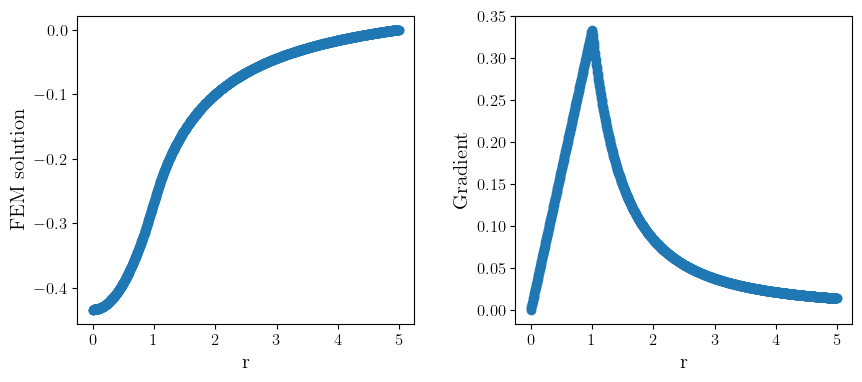

In [9]:
# Plot the obtained solution together with its gradient

r = wf.field.coors.squeeze()
sol = solver.sol
grad = wf.field.evaluate_at(r[:, np.newaxis], sol[:, np.newaxis], mode='grad').squeeze()

fig, axs = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)
axs[0].scatter(r, sol)
axs[0].set_xlabel("r", fontsize=15)
axs[0].set_ylabel("FEM solution", fontsize=15)
axs[1].scatter(r, grad)
axs[1].set_xlabel("r", fontsize=15)
axs[1].set_ylabel("Gradient", fontsize=15)
fig.subplots_adjust(wspace=0.3)
plt.show()

### 2) Assuming cylindrical symmetry

We can make this example a bit more complex by only assuming cylindrical symmetry on $\rho$. If we denote the cylindrical coordinate system by $(x, \varphi, z)$, we obtain the weak formulation
$$ \int_{\tilde{\Omega}} x \tilde{\boldsymbol{\nabla}} u \cdot \tilde{\boldsymbol{\nabla}} v \, \mathrm{d}x \mathrm{d}z + \alpha \int_{\tilde{\Omega}} x \rho(x, z) v \, \mathrm{d}x \mathrm{d}z = 0 \ ,$$
where $\tilde{\Omega} = \{(x, z) \text{ such that } \sqrt{x^2 + z^2} < R_c \}$ and $\tilde{\boldsymbol{\nabla}}$ denotes the reduced gradient operator such that $\tilde{\boldsymbol{\nabla}} u = (\partial_x u , \, \partial_z u)^T$.

#### Mesh generation

The mesh for this problem is a 2D mesh. We demonstrate how to generate it using the `MeshingTools` class. Here, the support of $\rho$ is assumed to be an ellipse.

In [14]:
from femtoscope.inout.meshfactory import MeshingTools

mt = MeshingTools(2)
s1 = mt.create_ellipse(rx=1.2, ry=0.6)
mt.create_subdomain(cell_size_min=0.05, cell_size_max=0.2,
                    dist_min=0, dist_max=4)
s2 = mt.create_ellipse(rx=5, ry=5)
mt.subtract_shapes(s2, s1, removeObject=True, removeTool=False)
mt.create_subdomain(cell_size_min=0.2, cell_size_max=0.2)
pre_mesh = mt.generate_mesh('mesh_test_potential.vtk', show_mesh=True, cylindrical_symmetry=True)

#### Entity selection
The entity selection with higher dimensional meshes (`dim >= 2`) is easier as topological entities of interest can be specified in the mesh file itself as physical groups (see `mesh_generation_basics` notebook). In *femtoscope*, regions are automatically saved (based on the registered physical groups) and can be accessed with their **region_key**. A region key is a tuple of the form `('type', no)`. As a reminder, here are the accepted types together with valid number:
- vertex entities `'vertex'` must be numbered between 0 and 99
- edge entities `'edge'` must be numbered between 100 and 199
- facet entities `'facet'` must be numbered between 200 and 299
- cell entities `'subomega'` must be numbered from 300

#### Implementing terms

The implementation of terms is similar to the 1D radial case.

In [13]:
def mat(ts, coors, mode=None, **kwargs):
    if mode != 'qp': return
    x = coors[:, 0]
    val = abs(x)
    return {'val': val.reshape(-1, 1, 1)}

t1 = PreTerm('dw_laplace', mat=mat)
t2 = PreTerm('dw_integrate', mat=mat, region_key=('subomega', 300))
pre_terms = [t1, t2]

#### `WeakForm` creation and solving

In [15]:
# Creation of the weak form
args_dict = {'dim': 2, 'pre_mesh': pre_mesh,
             'pre_ebc_dict': {('facet', 201): 0.0},
             'pre_terms': pre_terms,
             'fem_order': 2,
             }
wf = WeakForm.from_scratch(args_dict)

# Setting a linear solver and solving the problem
solver = LinearSolver({'wf_int': wf})
solver.solve()

#### Post-Processing

Post-processing in dimension `dim > 1` is a bit more complex. *femtoscope* features some tools in this regard.

In [ ]:
# Visualize the solution
import pyvista as pv
pv.set_jupyter_backend('trame')
solver.display_results()

Results can be also be saved to VTK files to allow for an offline post-process, e.g. with **Paraview** software.
The default location is `femtoscope\\data\\tmp`

In [16]:
solver.save_results_to_vtk('test.vtk')

More advanced feature regarding saving & offline post-processing are demonstrated in the `offline_postprocessing` notebook.